In [1]:
import os, time
from copy import deepcopy
import numpy as np
import pickle
from tqdm import tqdm

# Pytorch
import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
from torch.optim import Adam, SGD

from helpers import copy_sd, res_to_cpu, gen_corr
from rnn_model_dt import RNN_Net, find_fp
from task_generators import cycling, flipflop, mante, romo, complex_sine
task_gens = [cycling, flipflop, mante, romo, complex_sine]
task_names = [
    "cycling",
    "flipflop",
    "mante", 
    "romo", 
    "complex_sine", 
]

# Data path
from specs import data_path

Use cpu.


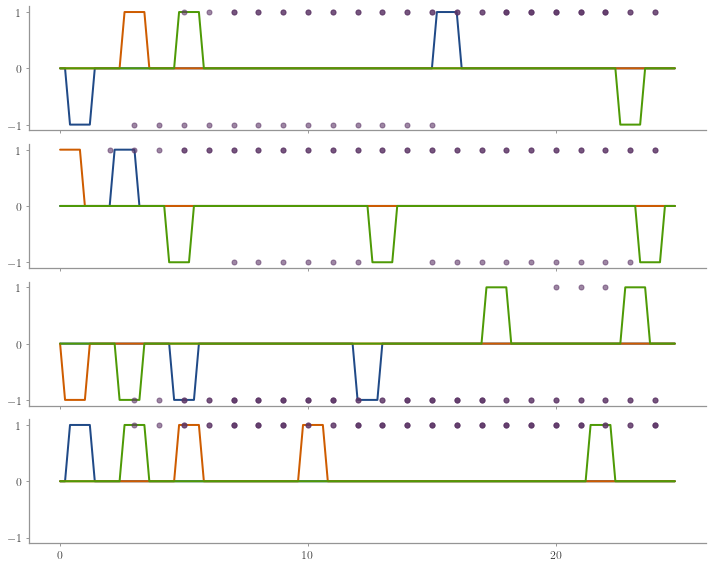

100%|███████████████████████████████████████| 4000/4000 [22:14<00:00,  3.00it/s]


Took 26499.0 sec.
Took 100.68 sec.
Took 13.85 sec.
Took 13.34 sec.
Saved to  ../../data/oblique/neuro_flipflop_n_512.pkl


In [2]:
# Select which tasks to train on.
task_names_train = [
    "cycling",
    "flipflop",
    "mante", 
    "romo", 
    "complex_sine", 
]

# Run training
for task_name in task_names_train:
    i_task = np.where(task_name == np.array(task_names))[0][0]
    task_generator = task_gens[i_task]

    # Parameters
    n_samples = 5

    # Network
    dim_hid = 512
    n_layers = 2
    bias = False
    train_in = True
    train_hid = True
    train_out = True
    train_layers = [train_in, train_hid, train_out]
    nonlin = torch.nn.Tanh()
    gaussian_init = True
    h_0_std = 0.
    dt = 0.2
    rec_step_dt = 1
    mask_step_dt = 5
    batch_size = 32
    task_params = dict(
        rec_step_dt=rec_step_dt,
    )
    # Noise on input, h_0, and hidden states
    noise_input_std = 0.0
    noise_init_std = 1.0
    noise_hid_std = 0.2

    # Joint scenarios
    out_scales = ['large', 'large', 'small', 'small']
    gs = [0.7, 1.5, 0.7, 1.5]
    n_sce = len(out_scales)
    opt_gens = [Adam]*n_sce
    n_mi = n_samples, n_sce

    if task_name == "cycling":
        n_steps = 1000
        lr0s = [0.02, 0.02, 0.02, 0.02]
        dim_in = 2
        dim_out = 2
    elif task_name == "flipflop":
        n_steps = 4000
        lr0s = [0.01, 0.01, 0.005, 0.005]
        n_fp = 3
        dim_in = n_fp
        dim_out = n_fp
        task_params["n_tasks"] = n_fp
    elif task_name == "mante":
        n_steps = 4000
        lr0s = [0.002, 0.02, 0.002, 0.002]
        n_tasks = 2
        dim_in = 2 * n_tasks
        dim_out = 1
        task_params["n_tasks"] = n_tasks
        noise_hid_std = 0.05
    elif task_name == "romo":
        n_steps = 6000
        lr0s = [0.01, 0.01, 0.01, 0.005]
        dim_in = 1
        dim_out = 1
    elif task_name == "complex_sine":
        n_steps = 6000
        lr0s = [0.01, 0.005, 0.005, 0.005]
        dim_in = 1
        dim_out = 1
        mask_step_dt = 2
    task_params["mask_step_dt"] = mask_step_dt

    # Task generators and fixed eval task
    task_gen = task_generator(dim_in, dim_out, dt, **task_params)
    task_params_ev = deepcopy(task_params)
    task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
    ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
    noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
    noise_init_ev = noise_init_std * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
    n_t_ev = len(ts_ev)
    task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev

    ##############################################################################
    # Train networks
    # Loss
    loss_crit = torch.nn.MSELoss()

    # Results arrays
    n_if = 2
    n_ifn = 4
    steps = torch.arange(n_steps)
    loss_all = torch.zeros((*n_mi, n_steps))
    output_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_out))
    hids_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_hid))
    h_0_all = torch.zeros((*n_mi, n_layers-1, batch_size, dim_hid))
    sd_if_all = np.zeros((n_if, *n_mi), dtype=object)

    # Record during training?
    record_train = True
    n_rec_steps = n_steps
    rec_step_width = n_steps // n_rec_steps
    rec_steps = torch.arange(0, n_steps, rec_step_width)
    dw_out_norm_all = torch.zeros((*n_mi, n_rec_steps))
    dw_rec_norm_all = torch.zeros((*n_mi, n_rec_steps))
    h_norm_all = torch.zeros((*n_mi, n_rec_steps))
    dh_norm_all = torch.zeros((*n_mi, n_rec_steps))
    corr_w_h_all = np.zeros((*n_mi, n_rec_steps, 2))
    corr_w_dh_all = np.zeros((*n_mi, n_rec_steps, 2))

    # Task to device
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = [to_dev(arr) for arr in task_ev]

    # Run training
    time0 = time.time()
    for mi in np.ndindex(*n_mi):
        i_s, i_sce = mi
        out_scale = out_scales[i_sce]
        g = gs[i_sce]
        lr0 = lr0s[i_sce]
        opt_gen = opt_gens[i_sce]
        # Network instance
        net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                      dt, rec_step_dt, train_layers)
        net.to(device)
        # Initial state: the same for each batch!
        h_0 = h_0_std * torch.randn((n_layers - 1, 1, dim_hid), device=device)
        h_0 = torch.tile(h_0, (1, batch_size, 1))
        h_0_all[mi] = h_0.detach()

        # Optimizer
        if opt_gen == torch.optim.Adam:
            lr = lr0 / dim_hid
        else:
            lr = lr0
        opt = opt_gen(net.parameters(), lr=lr)

        # Save before training
        sd_if_all[0][mi]= copy_sd(net.state_dict)
        with torch.no_grad():
            # With noise
            output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                           h_0 + noise_init_ev, 
                                           noise_hid_std, last_time=False)
            output_all[0][mi] = output
            hids_all[0][mi] = hids[0]
            # No noise
            output, hids = net.forward_hid(input_ev, h_0, last_time=False)
            output_all[2][mi] = output
            hids_all[2][mi] = hids[0]

        # Train
        for step in tqdm(range(n_steps)):
            # Record
            # 500 iterations took 24 sec each without recording; 32 sec with
            if step % rec_step_width == 0:
                rec_step = step // rec_step_width
                with torch.no_grad():
                    # Norm of weight changes
                    w_out = net.decoder.weight
                    dw_out_norm_all[mi][rec_step] = torch.linalg.norm(
                        w_out - sd_if_all[0][mi]["decoder.weight"]).item()
                    dw_rec_norm_all[mi][rec_step] = torch.linalg.norm(
                        net.rnn.weight_hh_l0 - sd_if_all[0][mi]["rnn.weight_hh_l0"]).item()
                    if record_train:
                        # Dynamics without noise 
                        output, hids = net.forward_hid(input_ev, h_0)
                        hids = hids[0]
                        # Norm of hidden states (and changes)
                        h_norm_all[mi][rec_step] = hids.norm(dim=-1).mean().item()
                        dhids = hids - hids_all[2][mi].to(device)
                        dh_norm_all[mi][rec_step] = dhids.norm(dim=-1).mean().item()
                        # Correlation between hidden states and output weights
                        corr_w_h_all[mi][rec_step] = gen_corr(hids, w_out)
                        corr_w_dh_all[mi][rec_step] = gen_corr(dhids, w_out)

            opt.zero_grad()
            # Draw an independent task each time
            task = task_gen(batch_size)
            _, input, target, mask = [to_dev(arr) for arr in task]
            # Draw independent input noise every time!
            noise_init = noise_init_std * torch.randn_like(h_0)
            noise_input = noise_input_std * torch.randn_like(input) / np.sqrt(dt)
            output = net(input + noise_input, h_0 + noise_init, noise_hid_std)
            loss = loss_crit(output[mask], target[mask])
            loss.backward()
            opt.step()
            loss_all[mi][step] = loss.item()

        # Save after training
        sd_if_all[1][mi] = copy_sd(net.state_dict)
        with torch.no_grad():
            # With noise
            _, input, target, mask = [to_dev(arr) for arr in task]
            output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                           h_0 + noise_init_ev, 
                                           noise_hid_std, last_time=False)
            output_all[1][mi] = output
            hids_all[1][mi] = hids[0]
            # No noise
            output, hids = net.forward_hid(input_ev, h_0, last_time=False)
            output_all[3][mi] = output
            hids_all[3][mi] = hids[0]
    print("Training took %.1f sec." % (time.time() - time0))

    #######################################################################################
    # Move everything to cpu!
    res_list = [sd_if_all]
    res_to_cpu(res_list)

    # Save
    save_data = True
    if save_data:
        res = [
            n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
            dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
            gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
            task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, 
            loss_all, output_all, 
            hids_all, 
            h_0_all, sd_if_all, record_train,     
            n_rec_steps, rec_step_width, rec_steps, h_norm_all, dh_norm_all, 
            dw_out_norm_all, dw_rec_norm_all, corr_w_h_all, corr_w_dh_all, 
        ]
        # Save data
        file_name = "neuro_noisy_" + task_name + "_n_%d" % dim_hid
        file_name = "_".join(file_name.split('.'))
        data_file = os.path.join(data_path, file_name + ".pkl")
        with open(data_file, 'wb') as handle:
            pickle.dump(res, handle)
        print('Saved to ', data_file)